# Analysis of important features in the reconstruction



SOME STUFF

In [24]:
import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt

import ultraplot as plot 

from typing import overload
import uproot
import mplhep as hep
import hist
import hist.intervals
import hist.plot

plot.rc['figure.facecolor'] = 'none'
plot.rc['savefig.facecolor'] = 'none'
plot.rc['legend.frameon'] = False
plot.rc['axes.autolimit_mode'] = 'data'

plot.rc['cmap.levels'] = 10

class Component:
    def __init__(self, data, tree_base='{}'):
        self.data = data
        self.tree_base = tree_base

    def get(self, stage1: str | list[str], product: str | list[str], binning, product_thr: float | list[float] = -100):

        if not isinstance(stage1, list):
            stage1 = [stage1]

        if not isinstance(product, list):
            product = [product]

        if not isinstance(product_thr, list):
            product_thr = [product_thr] * len(product)
        

        if not isinstance(binning, list) and len(product) > 1:
            binning = [binning] * len(product)
        
        data = []
        hists = []
    
        for e in stage1:
            data.append(self.data[self.tree_base.format(e)].arrays(library='pd'))

        
        d0 = data[0]
        common = d0
        for i in range(1, len(data)):
            d = data[i]
            common = pd.merge(
                d0[(d0[product] > product_thr).all(axis=1)][['event', *product]], 
                d[(d[product] > product_thr).all(axis=1)][['event', *product]], 
                on='event', suffixes=('', '_more')
            )
            # print(common.keys())
            d0 = common

        return_data = []
        for d in data:
            if len(product) == 1:
                hists.append(hist.Hist(binning).fill(d[d.event.isin(common.event)][product[0]].values))
            else:
                fill_data = [d[d.event.isin(common.event)][p].values for p in product]
                hists.append(hist.Hist(*binning).fill(*fill_data))
                return_data.append(d[d.event.isin(common.event)][['event', *product]])
            if False:
                print('ERROR: only 1D and 2D histograms are supported. The provided list of products exceed dimensionality: {}'.format(product))
            
        return hists, return_data
            
    def keys(self, stage1):
        return self.data[self.tree_base.format(stage1)].keys()


In [25]:

variables_1u1p = Component(uproot.open('2k_v2_variables_1u1p.root:tests'))


In [26]:
variables_1u1p.get(['nominal', 'cheated_2d'], ['muon_purity', 'muon_completeness'], hist.axis.Regular(100, 0, 1))

([Hist(
    Regular(100, 0, 1, label='Axis 0'),
    Regular(100, 0, 1, label='Axis 0'),
    storage=Double()) # Sum: 2368.0 (2554.0 with flow),
  Hist(
    Regular(100, 0, 1, label='Axis 0'),
    Regular(100, 0, 1, label='Axis 0'),
    storage=Double()) # Sum: 1123.0 (2554.0 with flow)],
 [          event  muon_purity  muon_completeness
  29     272076.0     0.912162           0.992647
  36     272088.0     0.883077           0.991364
  39     272093.0     0.903539           0.991622
  195    322446.0     0.911494           0.993734
  326    363043.0     0.904130           0.940906
  ...         ...          ...                ...
  82947  474879.0     0.938678           0.961741
  82949  474884.0     0.853271           0.925963
  82960  461742.0     0.915493           1.000000
  82976  461771.0     0.930813           0.993907
  83006  461824.0     0.887814           0.993506
  
  [2554 rows x 3 columns],
            event  muon_purity  muon_completeness
  29     272076.0     0.997549 

In [27]:
variables_1u1p.keys('nominal')

['event',
 'dE',
 'reco_E',
 'true_E',
 'reco_pT',
 'vertex_difference',
 'vertex_difference_x',
 'vertex_difference_y',
 'vertex_difference_z',
 'muon_purity',
 'muon_completeness',
 'proton_purity',
 'proton_completeness',
 'pid_muon_L_reco_true_ratio',
 'pid_proton_L_reco_true_ratio',
 'pid_muon_P_reco_true_ratio',
 'pid_proton_P_reco_true_ratio',
 'pid_muon_true_L',
 'pid_muon_reco_L',
 'epid_muon_L_ratio_proxy',
 'pid_proton_true_L',
 'pid_proton_reco_L',
 'pid_muon_R',
 'pid_proton_R',
 'muon_momentum_rangeP',
 'proton_momentum_rangeP',
 'CT3D_rangeP',
 'CT3D_trueP']

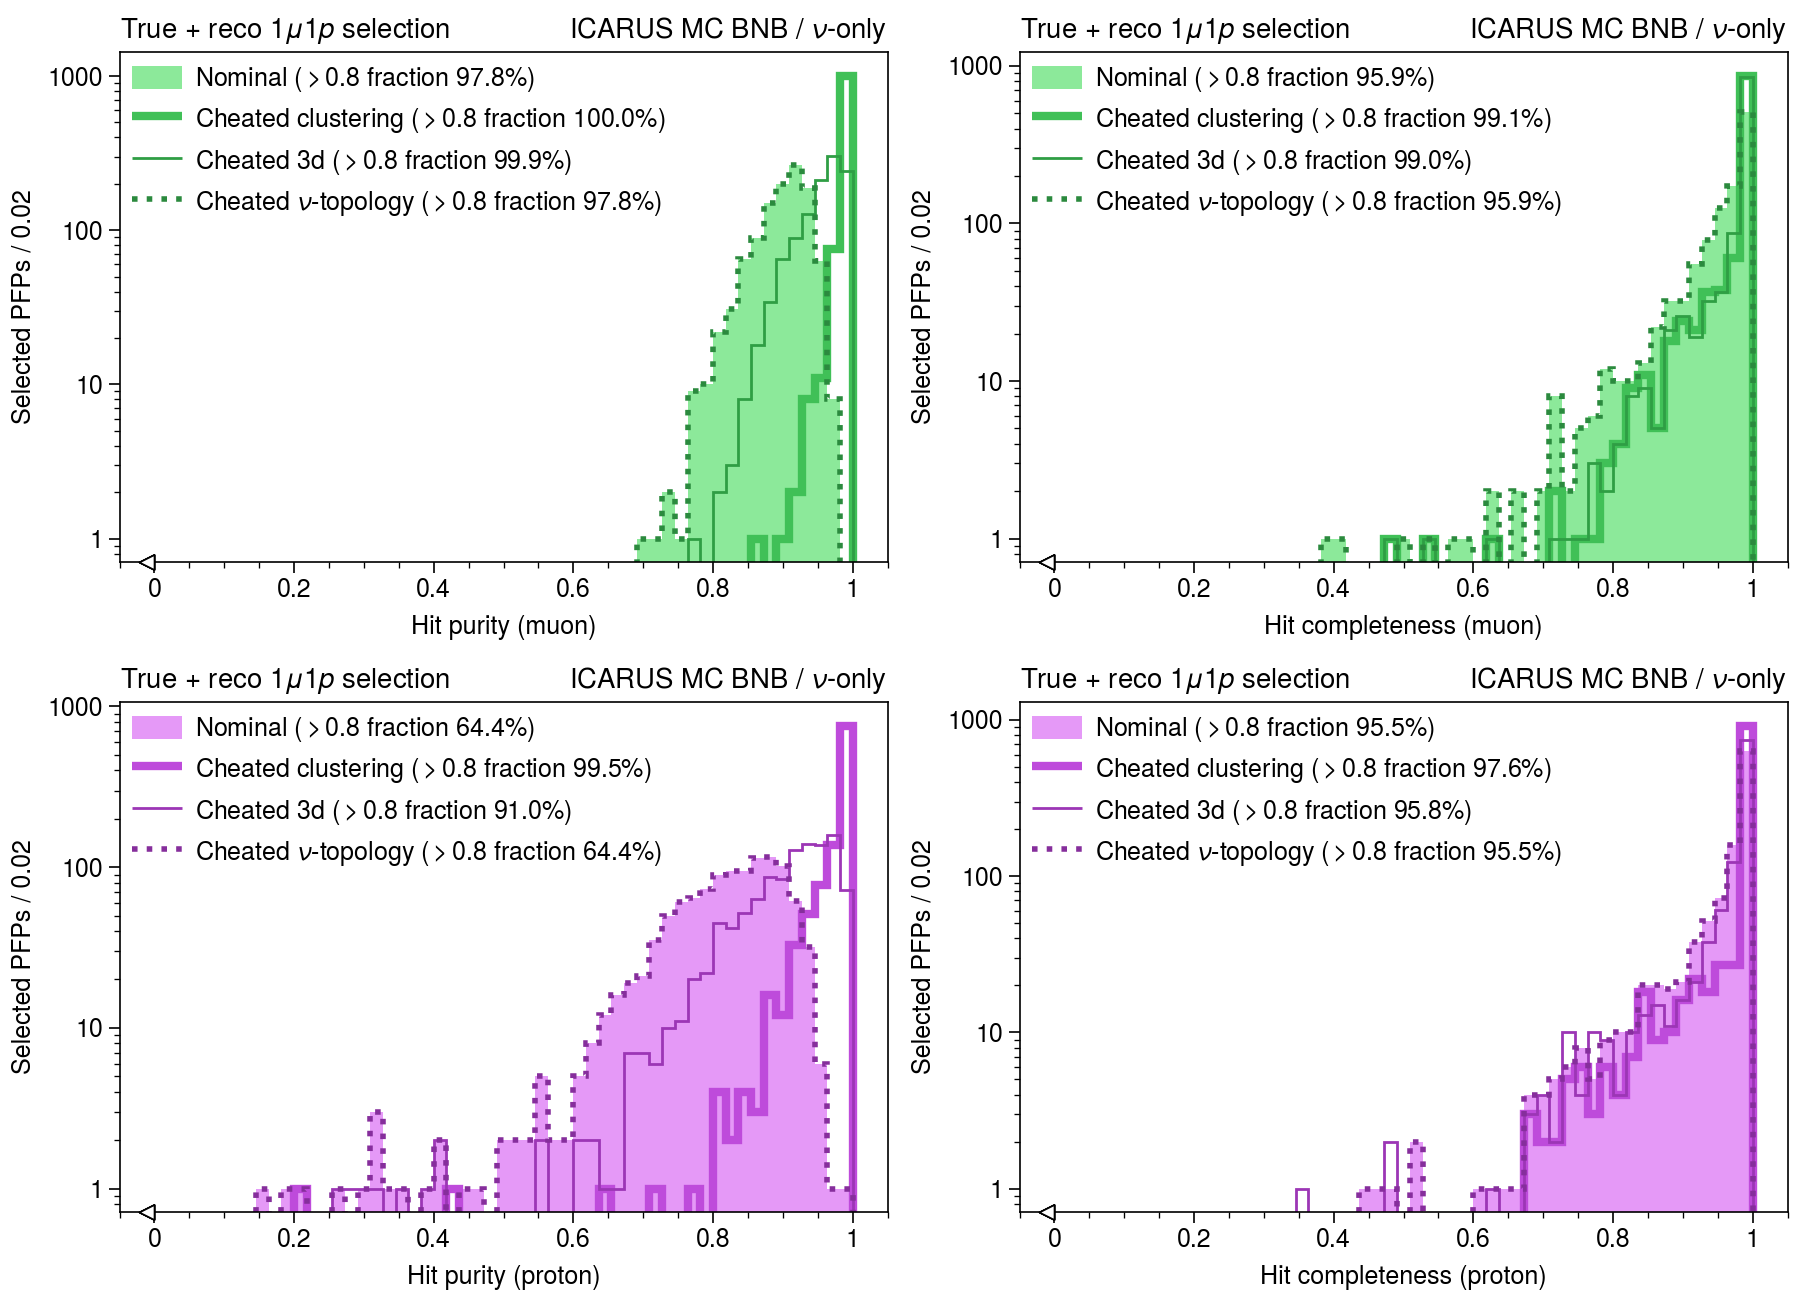

In [51]:
binning=hist.axis.Regular(55, 0, 1, overflow=False, name='hits')

fig, ax = plot.subplots(
    width=9, height=6.5, ncols=2, nrows=2, 
    xlabel=r'Hits', ylabel=f'Selected PFPs / {binning.widths[0]:.2f}',  
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only', 
    ltitle='True + reco $1\\mu1p$ selection',
    yscale='log'
)

A_colors = {
    'muon': 'green3',
    'proton': 'grape3'
}


B_colors = {
    'muon': 'green6',
    'proton': 'grape6'
}

C_colors = {
    'muon': 'green8',
    'proton': 'grape8'
}

D_colors = {
    'muon': 'green9',
    'proton': 'grape9'
}


for idx_p, particle in enumerate(['muon', 'proton']):
    for idx_l, label in enumerate(['purity', 'completeness']):
        (A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_3d', 'cheated_nuH'], f'{particle}_{label}', binning=binning)
        hep.histplot(A, ax=ax[idx_p, idx_l], density=False, yerr=False, label=f'Nominal ($>0.8$ fraction {A[hist.loc(0.8):hist.loc(1.1)].counts().sum()/A.counts().sum():.1%})', histtype='fill', color=A_colors[particle])
        hep.histplot(B, ax=ax[idx_p, idx_l], density=False, yerr=False, label=f'Cheated clustering ($>0.8$ fraction {B[hist.loc(0.8):hist.loc(1.1)].counts().sum()/B.counts().sum():.1%})', color=B_colors[particle], lw=3)
        hep.histplot(C, ax=ax[idx_p, idx_l], density=False, yerr=False, label=f'Cheated 3d ($>0.8$ fraction {C[hist.loc(0.8):hist.loc(1.1)].counts().sum()/C.counts().sum():.1%})', color=C_colors[particle], lw=1)
        hep.histplot(D, ax=ax[idx_p, idx_l], density=False, yerr=False, label=f'Cheated $\\nu$-topology ($>0.8$ fraction {D[hist.loc(0.8):hist.loc(1.1)].counts().sum()/D.counts().sum():.1%})', color=D_colors[particle], lw=2, ls=':')
        ax[idx_p, idx_l].format(
            xlabel=f'Hit {label} ({particle})',
        )
        ax[idx_p, idx_l].legend(ncols=1, loc='ul')


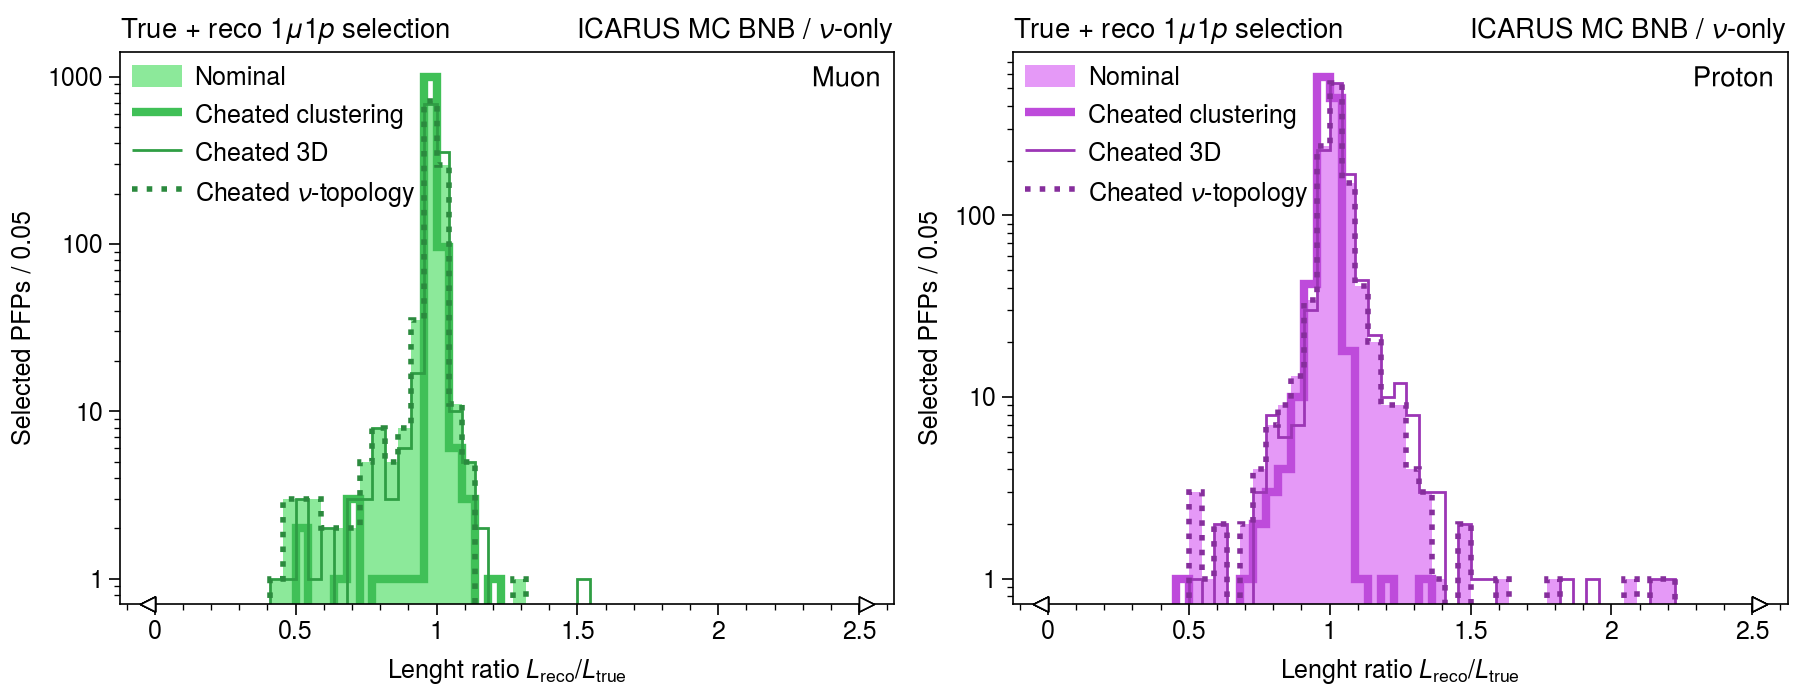

In [52]:
binning=hist.axis.Regular(55, 0, 2.5)

fig, axs = plot.subplots(
    width=9, height=3.5, ncols=2, nrows=1, 
    xlabel=r'Lenght ratio $L_\text{reco}/L_\text{true}$', ylabel=f'Selected PFPs / {binning.widths[0]:.2f}',  
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only', 
    ltitle='True + reco $1\\mu1p$ selection',
    yscale='log'
)

label_dict = {
    'muon': 'Muon',
    'proton': 'Proton'
}

A_colors = {
    'muon': 'green3',
    'proton': 'grape3'
}


B_colors = {
    'muon': 'green6',
    'proton': 'grape6'
}

C_colors = {
    'muon': 'green8',
    'proton': 'grape8'
}

D_colors = {
    'muon': 'green9',
    'proton': 'grape9'
}

for ax, particle in zip(axs, ['muon', 'proton']):
    (A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_3d', 'cheated_nuH'], f'pid_{particle}_L_reco_true_ratio', binning=binning)
    hep.histplot(A, ax=ax, density=False, yerr=False, label=f'Nominal', histtype='fill', color=A_colors[particle])
    hep.histplot(B, ax=ax, density=False, yerr=False, label=f'Cheated clustering', color=B_colors[particle], lw=3)
    hep.histplot(C, ax=ax, density=False, yerr=False, label=f'Cheated 3D', color=C_colors[particle], lw=1)
    hep.histplot(D, ax=ax, density=False, yerr=False, label=f'Cheated $\\nu$-topology', color=D_colors[particle], lw=2, ls=':')
    ax.format(urtitle=label_dict[particle])
    ax.legend(ncols=1, loc='ul')

A_colors['muon'] = 'orange3'
C_colors['muon'] = 'orange8'
B_colors['muon'] = 'orange6'
D_colors['muon'] = 'orange9'

# for ax, particle in zip(axs, ['muon']):
#     (A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx', 'cheated_2d_vtx_3d_nu_mva'], f'epid_{particle}_L_ratio_proxy', binning=binning)
#     hep.histplot(A, ax=ax, density=False, yerr=False, alpha=0.5, label=f'Nominal (end-start difference)', histtype='fill', hatch='////', color=A_colors[particle])
#     hep.histplot(C, ax=ax, density=False, yerr=False, alpha=0.5, label=f'Cheated vertex (end-start difference)', color=C_colors[particle], lw=1)
#     hep.histplot(B, ax=ax, density=False, yerr=False, alpha=0.5, label=f'Cheated clustering (end-start difference)', color=B_colors[particle], lw=3)
#     hep.histplot(D, ax=ax, density=False, yerr=False, alpha=0.5, label=f'Cheated (end-start difference)', color=D_colors[particle], lw=2, ls=':')
#     ax.format(urtitle=label_dict[particle])
#     ax.legend(ncols=1, loc='ul')


In [30]:
_, (a,b) = variables_1u1p.get(['nominal', 'cheated_2d'], ['pid_muon_L_reco_true_ratio', 'epid_muon_L_ratio_proxy'], binning=binning)

a[a.pid_muon_L_reco_true_ratio>1.15].sort_values('event')

,event,pid_muon_L_reco_true_ratio,epid_muon_L_ratio_proxy
43850,23686.0,1.215427,1.210107
46394,26367.0,1.183913,0.988258
21731,44453.0,2.403058,2.240946
26608,46578.0,3.008884,2.839183
26309,50973.0,1.160285,1.052929
40410,57838.0,2.456150,2.387773
16639,120082.0,1.274431,0.943243
4181,259768.0,1.163993,1.011582
49842,302121.0,1.312229,1.228012
67199,302392.0,1.183408,0.990199


In [31]:
b[(b.pid_muon_L_reco_true_ratio>1.15) & b.event.isin(a[a.pid_muon_L_reco_true_ratio>1.15].event)].sort_values('event')

,event,pid_muon_L_reco_true_ratio,epid_muon_L_ratio_proxy
46417,26367.0,1.223549,0.989522


In [32]:
b[(b.pid_muon_L_reco_true_ratio>1.5) & b.event.isin(a[a.pid_muon_L_reco_true_ratio<1.].event)].sort_values('event')

,event,pid_muon_L_reco_true_ratio,epid_muon_L_ratio_proxy
48101,257099.0,2.520877,1.799604
10819,448531.0,2.536493,2.263672
1195,449396.0,2.379162,1.356195
17541,467417.0,6.725019,4.715153


In [33]:
both = pd.merge(a, b, on='event', suffixes=('_nominal', '_2Dc'))
both[(both.pid_muon_L_reco_true_ratio_2Dc>1.5) & (both.pid_muon_L_reco_true_ratio_nominal<1.)].sort_values('event')

,event,pid_muon_L_reco_true_ratio_nominal,epid_muon_L_ratio_proxy_nominal,pid_muon_L_reco_true_ratio_2Dc,epid_muon_L_ratio_proxy_2Dc
1474,257099.0,0.998450,0.993968,2.520877,1.799604
310,448531.0,0.963965,0.958813,2.536493,2.263672
33,449396.0,0.959231,0.947402,2.379162,1.356195
508,467417.0,0.993433,0.992439,6.725019,4.715153


In [34]:
_, (a,b) = variables_1u1p.get(['nominal', 'cheated_2d'], ['pid_muon_L_reco_true_ratio', 'pid_muon_true_L', 'pid_muon_reco_L', 'epid_muon_L_ratio_proxy'], binning=binning)
both = pd.merge(a, b, on='event', suffixes=('_nominal', '_2Dc'))
selected = both[(both.pid_muon_L_reco_true_ratio_2Dc>1.5) & (both.pid_muon_L_reco_true_ratio_nominal<1.)].sort_values('event')
selected[selected.pid_muon_true_L_nominal>150]

,event,pid_muon_L_reco_true_ratio_nominal,pid_muon_true_L_nominal,pid_muon_reco_L_nominal,epid_muon_L_ratio_proxy_nominal,pid_muon_L_reco_true_ratio_2Dc,pid_muon_true_L_2Dc,pid_muon_reco_L_2Dc,epid_muon_L_ratio_proxy_2Dc
310,448531.0,0.963965,153.889389,148.343933,0.958813,2.536493,153.889389,390.339386,2.263672
33,449396.0,0.959231,179.473862,172.156906,0.947402,2.379162,179.473862,426.997345,1.356195


In [35]:
both[both.event == 262182]

,event,pid_muon_L_reco_true_ratio_nominal,pid_muon_true_L_nominal,pid_muon_reco_L_nominal,epid_muon_L_ratio_proxy_nominal,pid_muon_L_reco_true_ratio_2Dc,pid_muon_true_L_2Dc,pid_muon_reco_L_2Dc,epid_muon_L_ratio_proxy_2Dc


In [36]:
both[both.event == 366414]

,event,pid_muon_L_reco_true_ratio_nominal,pid_muon_true_L_nominal,pid_muon_reco_L_nominal,epid_muon_L_ratio_proxy_nominal,pid_muon_L_reco_true_ratio_2Dc,pid_muon_true_L_2Dc,pid_muon_reco_L_2Dc,epid_muon_L_ratio_proxy_2Dc
1661,366414.0,0.736488,338.854065,249.56189,0.72992,0.989421,338.854065,335.26944,0.970247


In [37]:
both[both.event == 260959]

,event,pid_muon_L_reco_true_ratio_nominal,pid_muon_true_L_nominal,pid_muon_reco_L_nominal,epid_muon_L_ratio_proxy_nominal,pid_muon_L_reco_true_ratio_2Dc,pid_muon_true_L_2Dc,pid_muon_reco_L_2Dc,epid_muon_L_ratio_proxy_2Dc
1597,260959.0,0.999388,304.656189,304.469635,0.989425,0.997777,304.656189,303.979065,0.987858


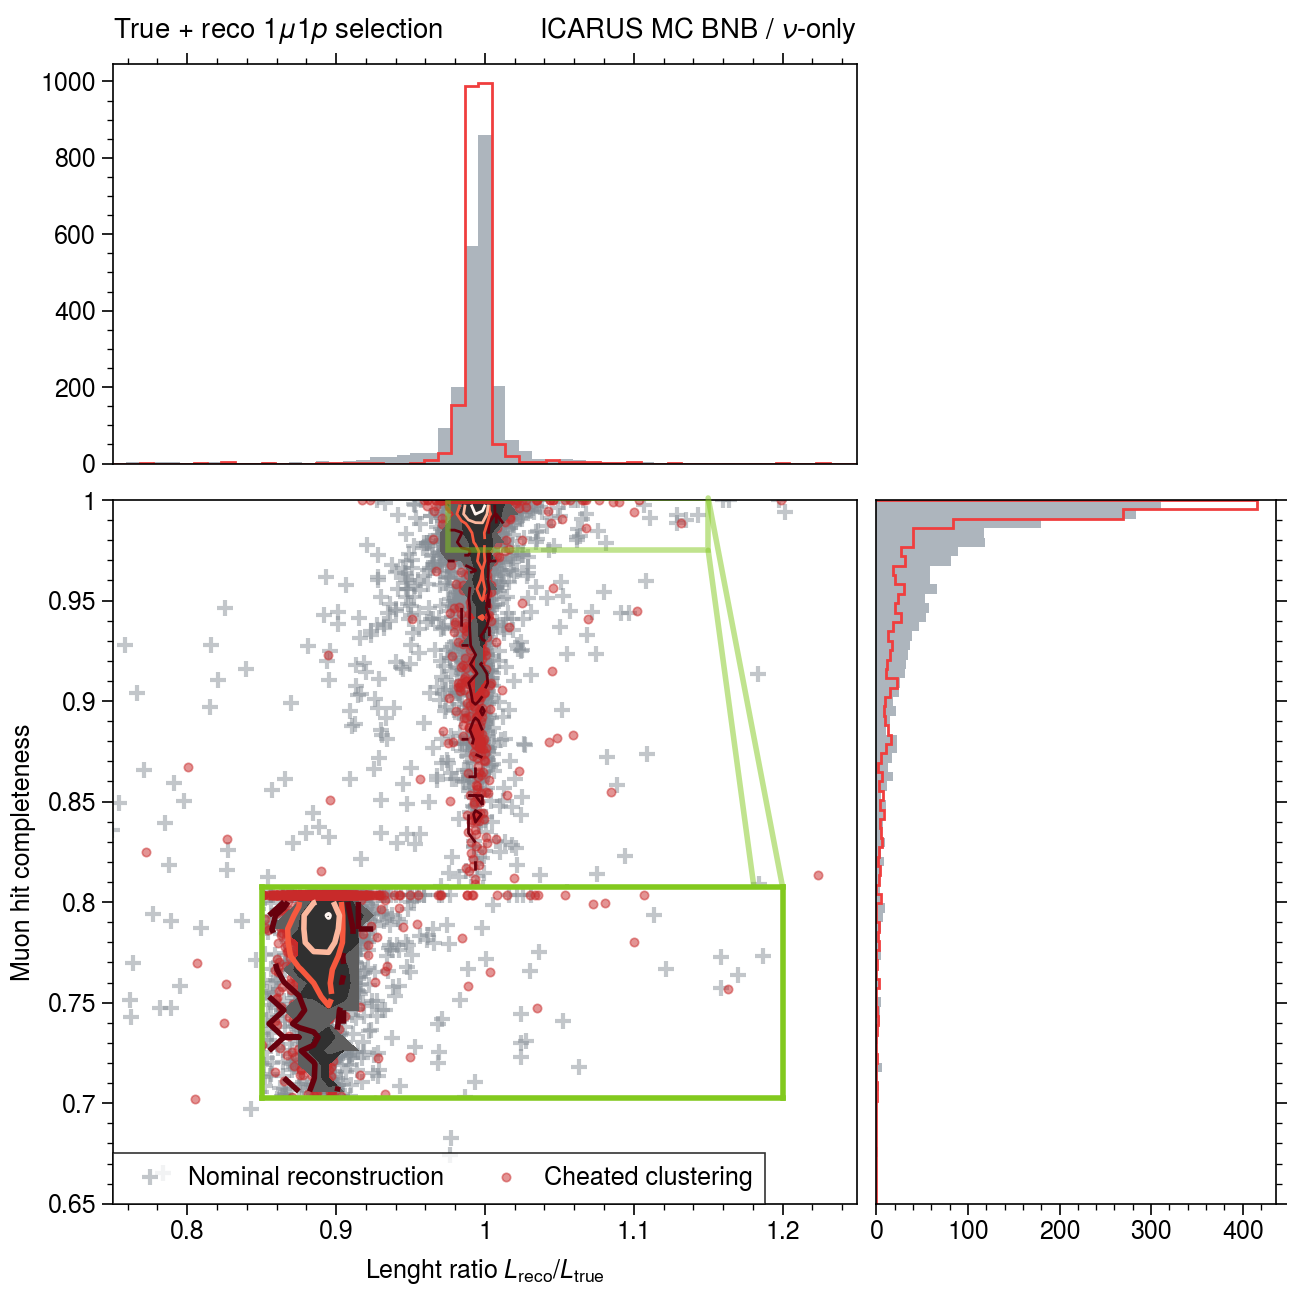

In [38]:
binning=[hist.axis.Regular(75, 0.8, 1.15), hist.axis.Regular(75, 0.65, 1)] # ratio, hit completeness
plot.rc['cmap.levels'] = 6

fig, ax = plot.subplots(
    width=6.5, height=6.5, ncols=1, nrows=1, 
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only',
    ltitle='True + reco $1\\mu1p$ selection',
    # yscale='log'
)

(a, b, c), (A, B, C) = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx'], ['pid_muon_L_reco_true_ratio', 'muon_completeness'], binning=binning)

A = A[(A.pid_muon_L_reco_true_ratio>0) & (A.muon_completeness>0)]
B = B[(B.pid_muon_L_reco_true_ratio>0) & (B.muon_completeness>0)]

ax=ax[0]
ax.scatter(A.pid_muon_L_reco_true_ratio, A.muon_completeness, color='gray6', alpha=0.5, marker='+', label='Nominal reconstruction')
ax.scatter(B.pid_muon_L_reco_true_ratio, B.muon_completeness, color='red9', alpha=0.5, marker='.', label='Cheated clustering')


H, xe, ye = a.to_numpy()
H = np.ma.masked_where(H <= 3, H)
ax.contourf(xe, ye, H.T, norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), cmap='Black', lw=0)
H, xe, ye = b.to_numpy()
H = np.ma.masked_where(H <= 0, H)
ax.contour(xe, ye, H.T, cmap='Reds_r', norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), alpha=1, lw=1, label=r'Cheated clustering')

ix = ax.inset_axes((0.2, 0.15, 0.7, 0.3), transform='axes')

(a, b, c), (A, B, C) = variables_1u1p.get(
    ['nominal', 'cheated_2d', 'cheated_vtx'], ['pid_muon_L_reco_true_ratio', 'muon_completeness'], 
    binning=[hist.axis.Regular(35, 0.975, 1.15), hist.axis.Regular(15, 0.975, 1)]
)

A = A[(A.pid_muon_L_reco_true_ratio>0) & (A.muon_completeness>0)]
B = B[(B.pid_muon_L_reco_true_ratio>0) & (B.muon_completeness>0)]

ix.scatter(A.pid_muon_L_reco_true_ratio, A.muon_completeness, color='gray6', alpha=0.5, marker='+', label='')
ix.scatter(B.pid_muon_L_reco_true_ratio, B.muon_completeness, color='red9', alpha=0.5, marker='.', label='')


H, xe, ye = a.to_numpy()
H = np.ma.masked_where(H <= 3, H)
ix.contourf(xe, ye, H.T, norm=mpl.colors.LogNorm(), vmin=0.2, vmax=2*H.max(), cmap='Black', lw=0)
H, xe, ye = b.to_numpy()
H = np.ma.masked_where(H <= 0, H)
ix.contour(xe, ye, H.T, cmap='Reds_r', norm=mpl.colors.LogNorm(), vmin=0.5, vmax=2*H.max(), alpha=1, lw=2)

ix.format(
    xlabel='', ylabel='', xlim=(0.975, 1.15), ylim=(0.975, 1.001),
    xticks=[], yticks=[], color='lime6', lw=2
)

ix.indicate_inset_zoom(lw=2, ec='lime6')

top = ax.panel(side='t', width=2)

(A, B, C, D), _ = variables_1u1p.get(
    ['nominal', 'cheated_2d', 'cheated_vtx', 'cheated_2d_vtx_3d_nu_mva'], 
    'pid_muon_L_reco_true_ratio', binning=hist.axis.Regular(55, 0.75, 1.25, flow=False)
)
hep.histplot(A, ax=top, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5')
hep.histplot(B, ax=top, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1)

right = ax.panel(side='r', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx', 'cheated_2d_vtx_3d_nu_mva'], 'muon_completeness', binning=hist.axis.Regular(75, 0.65, 1))
hep.histplot(A.to_numpy(), ax=right, density=False, yerr=False, histtype='fill', color='gray5', orientation='horizontal')
hep.histplot(B.to_numpy(), ax=right, density=False, yerr=False, color='red7', lw=1, orientation='horizontal')


right.format(
    xlabel=r'', ylabel='', ylim=(0.65, 1), grid=False
)
top.format(
    xlabel=r'Lenght ratio $L_\text{reco}/L_\text{true}$', ylabel='', xlim=(0.75, 1.25), grid=False
)
ax.format(
    xlabel=r'Lenght ratio $L_\text{reco}/L_\text{true}$', ylabel='Muon hit completeness',  
    xlim=(0.75, 1.25), ylim=(0.65, 1)
)
ax.legend(ncols=2, loc='ll', frameon=True)

fig.savefig('2k_lenght_ratio_vs_µ_completeness.pdf', bbox_inches='tight')

np.float64(32.0)

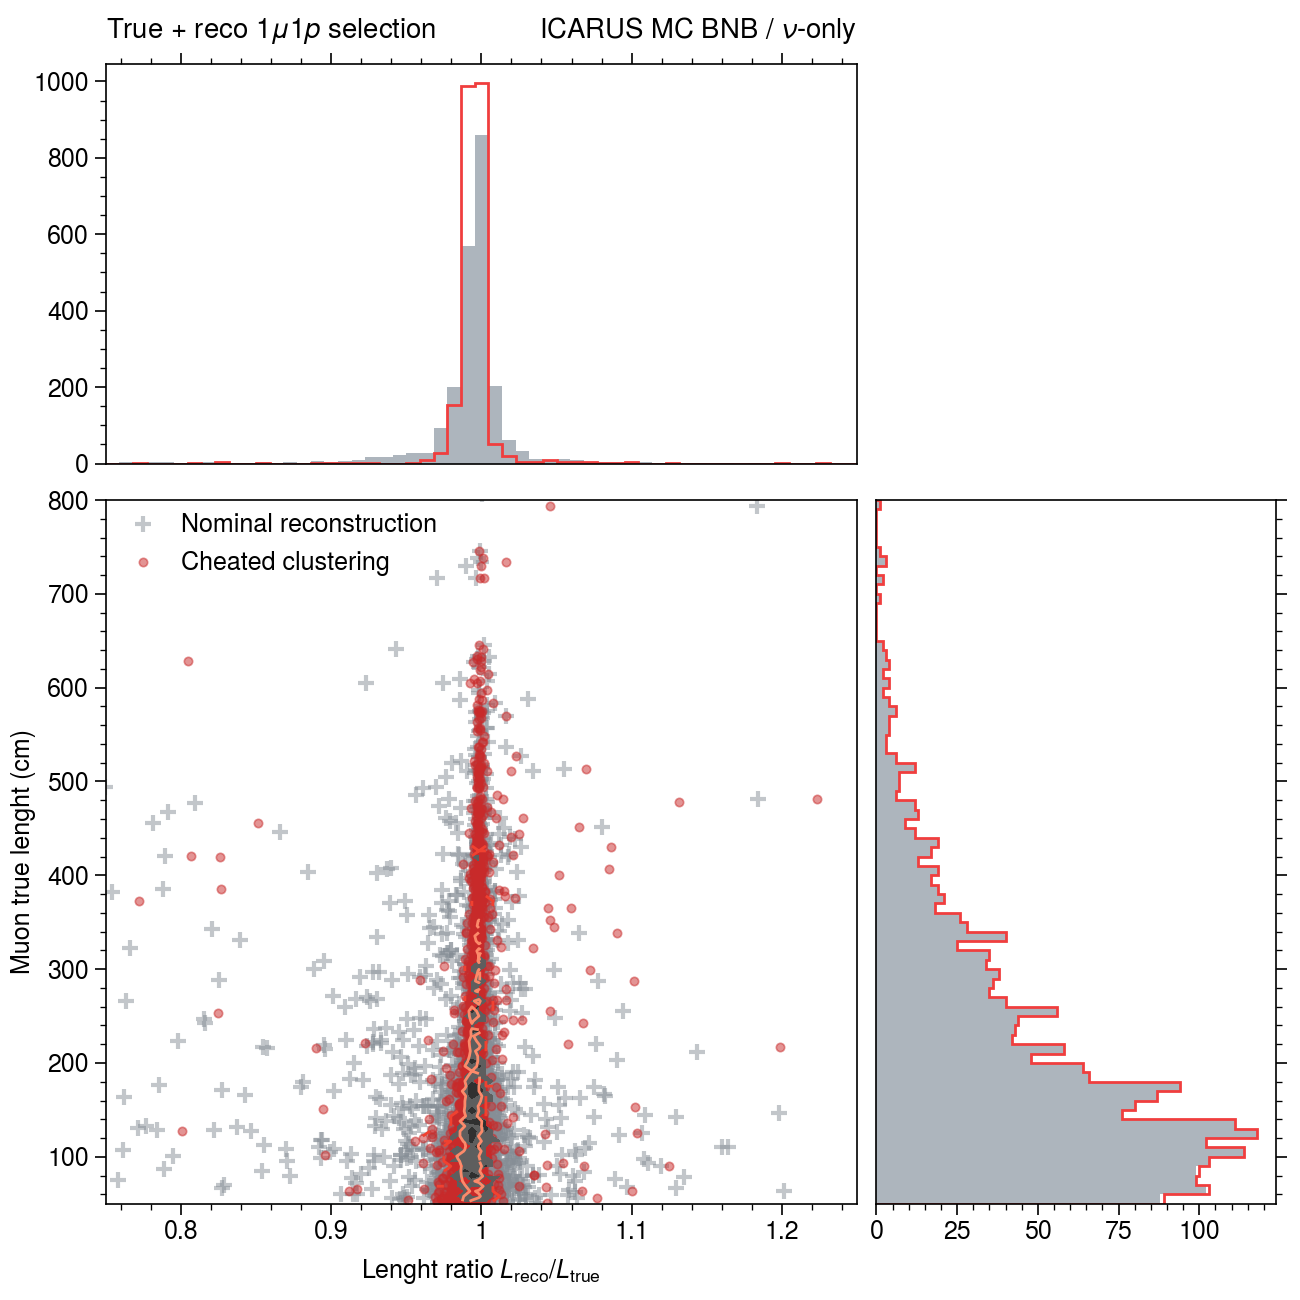

In [39]:
binning=[hist.axis.Regular(75, 0.8, 1.15), hist.axis.Regular(75, 50, 450)] # ratio, lenght
plot.rc['cmap.levels'] = 6

fig, axs = plot.subplots(
    width=6.5, height=6.5, ncols=1, nrows=1, 
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only',
    ltitle='True + reco $1\\mu1p$ selection',
    # yscale='log'
)

(a, b, c), (A, B, C) = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx'], ['pid_muon_L_reco_true_ratio', 'pid_muon_true_L'], binning=binning)

ax = axs[0]
A = A[A.pid_muon_L_reco_true_ratio>0]
B = B[B.pid_muon_L_reco_true_ratio>0]



ax.scatter(A.pid_muon_L_reco_true_ratio, A.pid_muon_true_L, color='gray6', alpha=0.5, marker='+', label='Nominal reconstruction')
ax.scatter(B.pid_muon_L_reco_true_ratio, B.pid_muon_true_L, color='red9', alpha=0.5, marker='.', label='Cheated clustering')


H, xe, ye = a.to_numpy()
H = np.ma.masked_where(H <= 3, H)
ax.contourf(xe, ye, H.T, norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), cmap='Black', lw=0)
H, xe, ye = b.to_numpy()
H = np.ma.masked_where(H <= 0, H)
ax.contour(xe, ye, H.T, cmap='Reds_r', norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), alpha=1, lw=1, label='Cheated clustering')


top = ax.panel(side='t', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx', 'cheated_2d_vtx_3d_nu_mva'], 'pid_muon_L_reco_true_ratio', binning=hist.axis.Regular(55, 0.75, 1.25, flow=False))
hep.histplot(A, ax=top, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5')
# hep.histplot(C, ax=top, density=False, yerr=False, label=f'Cheated vertex', color=C_colors[particle], lw=1)
hep.histplot(B, ax=top, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1)
# hep.histplot(D, ax=top, density=False, yerr=False, label=f'Cheated', color=D_colors[particle], lw=2, ls=':')

right = ax.panel(side='r', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx', 'cheated_2d_vtx_3d_nu_mva'], 'pid_muon_true_L', binning=hist.axis.Regular(75, 50, 800))
hep.histplot(A.to_numpy(), ax=right, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5', orientation='horizontal')
# hep.histplot(C, ax=top, density=False, yerr=False, label=f'Cheated vertex', color=C_colors[particle], lw=1)
hep.histplot(B.to_numpy(), ax=right, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1, orientation='horizontal')
# hep.histplot(D, ax=top, density=False, yerr=False, label=f'Cheated', color=D_colors[particle], lw=2, ls=':')


right.format(
    xlabel=r'', ylabel='', ylim=(50, 800), grid=False
)
top.format(
    xlabel=r'', ylabel='', xlim=(0.75, 1.25), grid=False
)
ax.format(
    xlabel=r'Lenght ratio $L_\text{reco}/L_\text{true}$', ylabel='Muon true lenght (cm)',  
    xlim=(0.75, 1.25), ylim=(50, 800)
)
ax.legend(ncols=1)

H.max()

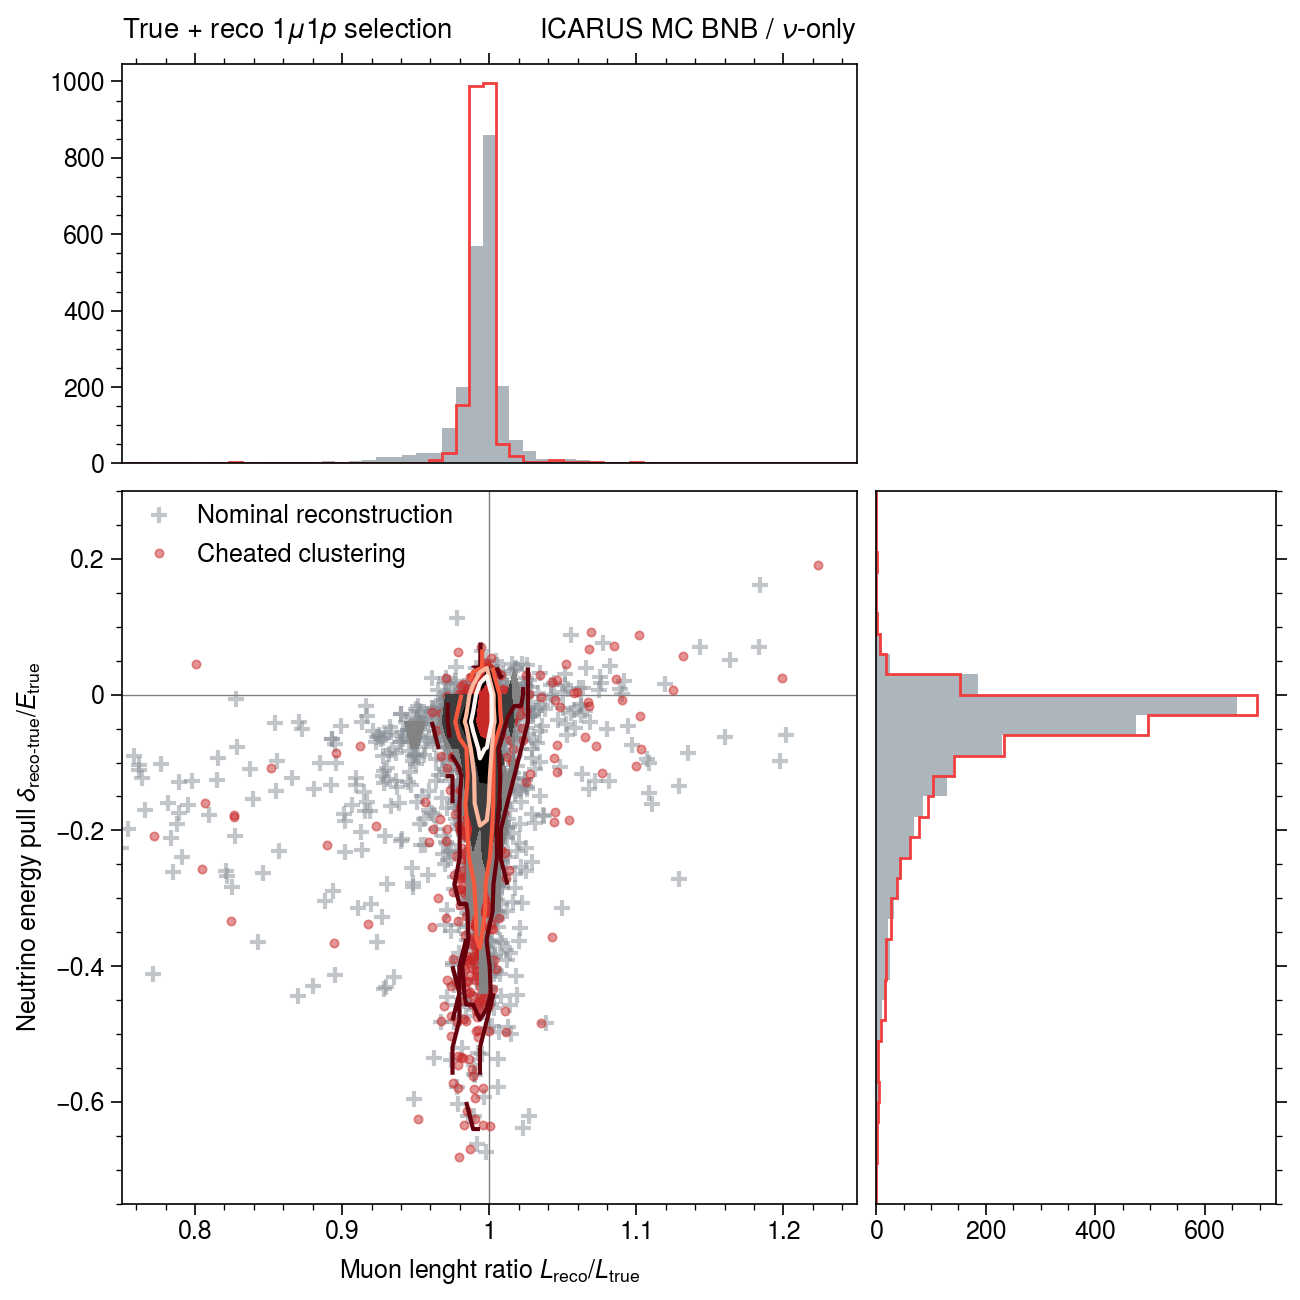

In [40]:
binning=[hist.axis.Regular(75, 0.8, 1.15), hist.axis.Regular(75, -1.5, 1.5)] # ratio, E pull
plot.rc['cmap.levels'] = 6

fig, axs = plot.subplots(
    width=6.5, height=6.5, ncols=1, nrows=1, 
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only',
    ltitle='True + reco $1\\mu1p$ selection',
    # yscale='log'
)

(a, b, c), (A, B, C) = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx'], ['pid_muon_L_reco_true_ratio', 'dE'], binning=binning)

ax = axs[0]
A = A[A.pid_muon_L_reco_true_ratio>0]
B = B[B.pid_muon_L_reco_true_ratio>0]



ax.scatter(A.pid_muon_L_reco_true_ratio, A.dE, color='gray6', alpha=0.5, marker='+', label='Nominal reconstruction')
ax.scatter(B.pid_muon_L_reco_true_ratio, B.dE, color='red9', alpha=0.5, marker='.', label='Cheated clustering')


H, xe, ye = a.to_numpy()
H = np.ma.masked_where(H <= 3, H)
ax.contourf(xe, ye, H.T, norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), cmap='Black', lw=0)
H, xe, ye = b.to_numpy()
H = np.ma.masked_where(H <= 0, H)
ax.contour(xe, ye, H.T, cmap='Reds_r', norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), alpha=1, lw=1.5, label='Cheated clustering')


top = ax.panel(side='t', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx', 'cheated_2d_vtx_3d_nu_mva'], 'pid_muon_L_reco_true_ratio', binning=hist.axis.Regular(55, 0.75, 1.25, flow=False))
hep.histplot(A, ax=top, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5')
# hep.histplot(C, ax=top, density=False, yerr=False, label=f'Cheated vertex', color=C_colors[particle], lw=1)
hep.histplot(B, ax=top, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1)
# hep.histplot(D, ax=top, density=False, yerr=False, label=f'Cheated', color=D_colors[particle], lw=2, ls=':')

right = ax.panel(side='r', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx', 'cheated_2d_vtx_3d_nu_mva'], 'dE', binning=hist.axis.Regular(100,  -1.5, 1.5))
hep.histplot(A.to_numpy(), ax=right, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5', orientation='horizontal')
# hep.histplot(C, ax=top, density=False, yerr=False, label=f'Cheated vertex', color=C_colors[particle], lw=1)
hep.histplot(B.to_numpy(), ax=right, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1, orientation='horizontal')
# hep.histplot(D, ax=top, density=False, yerr=False, label=f'Cheated', color=D_colors[particle], lw=2, ls=':')


right.format(
    xlabel=r'', ylabel='', ylim=(-.75, .3), grid=False
)
top.format(
    xlabel=r'', ylabel='', xlim=(0.75, 1.25), grid=False
)
ax.format(
    xlabel=r'Muon lenght ratio $L_\text{reco}/L_\text{true}$', ylabel=r'Neutrino energy pull $\delta_\text{reco-true}/E_\text{true}$',  
    xlim=(0.75, 1.25), ylim=(-.75, .3)
)
ax.legend(ncols=1)

ax.axhline(0, color='k', lw=0.5, alpha=0.5, zorder=-99)
ax.axvline(1, color='k', lw=0.5, alpha=0.5, zorder=-99)

H.max()

fig.savefig('2k_length_ratio_vs_energy_pull.pdf', bbox_inches='tight')

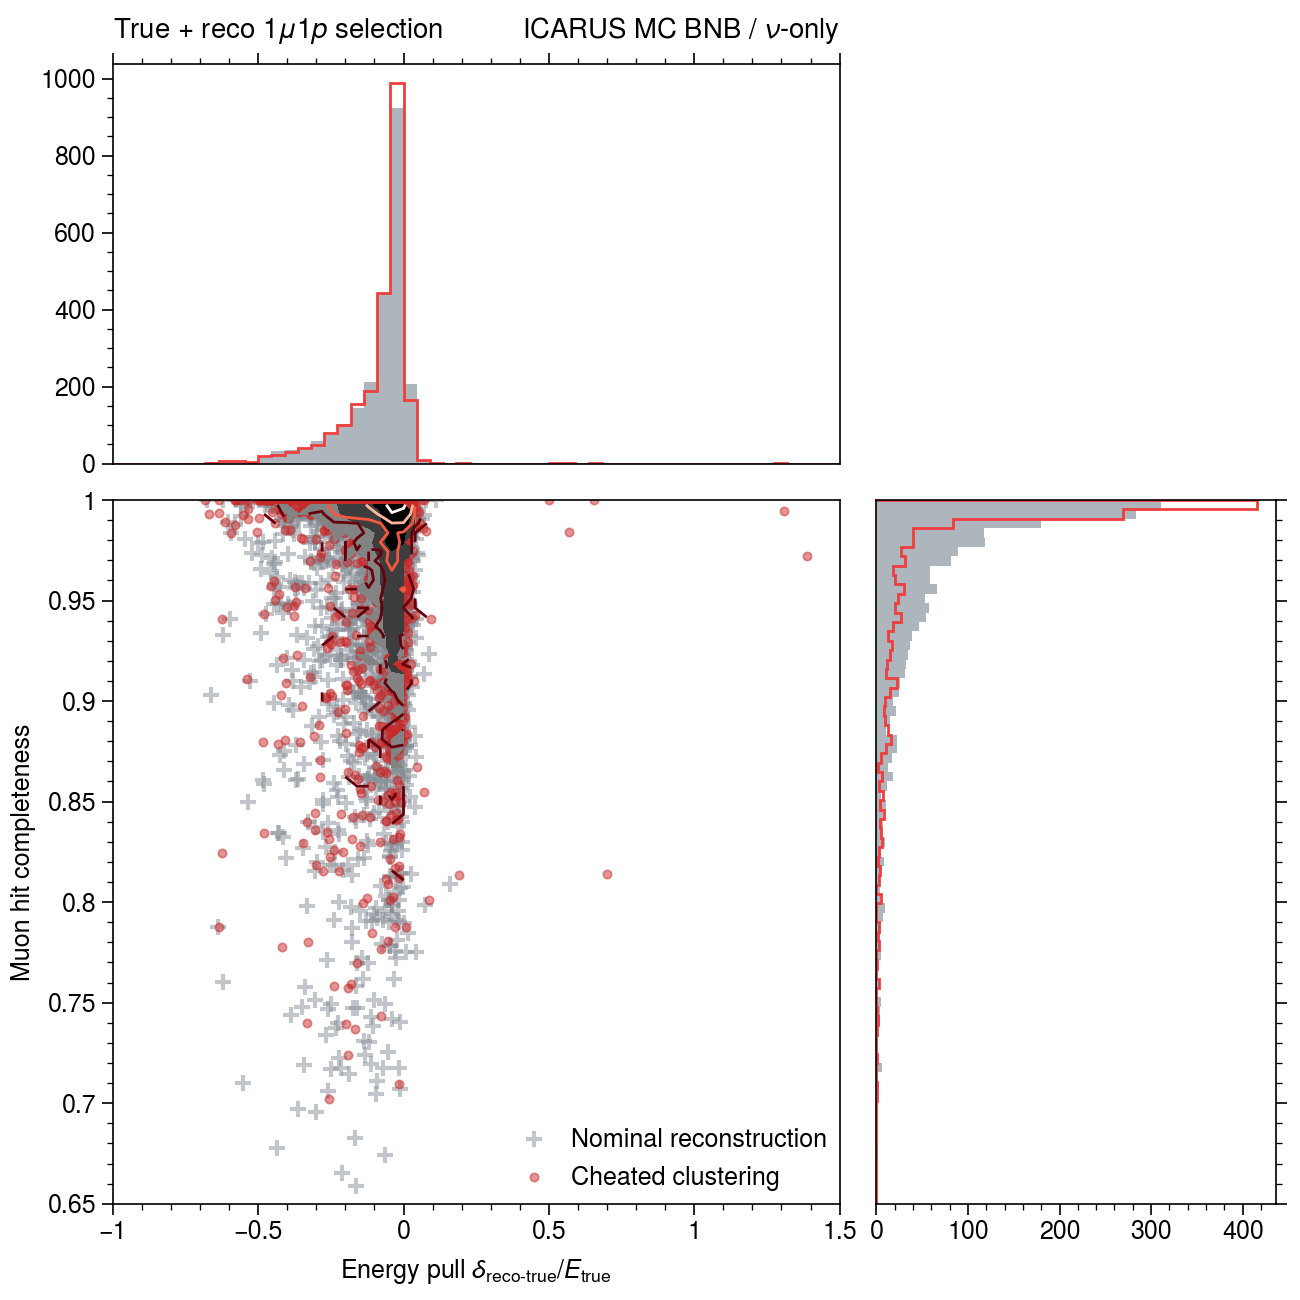

In [41]:
binning=[hist.axis.Regular(75, -1.5, 1.5), hist.axis.Regular(75, 0.65, 1)] # ratio, hit completeness
plot.rc['cmap.levels'] = 6

fig, axs = plot.subplots(
    width=6.5, height=6.5, ncols=1, nrows=1, 
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only',
    ltitle='True + reco $1\\mu1p$ selection',
    # yscale='log'
)

(a, b, c), (A, B, C) = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx'], ['dE', 'muon_completeness'], binning=binning)

ax = axs[0]
A = A[(A.dE>-100) & (A.muon_completeness>0)]
B = B[(B.dE>-100) & (B.muon_completeness>0)]



ax.scatter(A.dE, A.muon_completeness, color='gray6', alpha=0.5, marker='+', label='Nominal reconstruction')
ax.scatter(B.dE, B.muon_completeness, color='red9', alpha=0.5, marker='.', label='Cheated clustering')


H, xe, ye = a.to_numpy()
H = np.ma.masked_where(H <= 3, H)
ax.contourf(xe, ye, H.T, norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), cmap='Black', lw=0)
H, xe, ye = b.to_numpy()
H = np.ma.masked_where(H <= 0, H)
ax.contour(xe, ye, H.T, cmap='Reds_r', norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), alpha=1, lw=1, label='Cheated clustering')


top = ax.panel(side='t', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx', 'cheated_2d_vtx_3d_nu_mva'], 'dE', binning=hist.axis.Regular(55, -1., 1.5, flow=False))
hep.histplot(A, ax=top, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5')
hep.histplot(B, ax=top, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1)

right = ax.panel(side='r', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx', 'cheated_2d_vtx_3d_nu_mva'], 'muon_completeness', binning=hist.axis.Regular(75, 0.65, 1))
hep.histplot(A.to_numpy(), ax=right, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5', orientation='horizontal')
hep.histplot(B.to_numpy(), ax=right, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1, orientation='horizontal')


right.format(
    xlabel=r'', ylabel='', ylim=(0.65, 1), grid=False
)
top.format(
    xlabel=r'', ylabel='', xlim=(-1., 1.5), grid=False
)
ax.format(
    xlabel=r'Energy pull $\delta_\text{reco-true}/E_\text{true}$', ylabel='Muon hit completeness',  
    xlim=(-1., 1.5), ylim=(0.65, 1)
)
ax.legend(ncols=1)

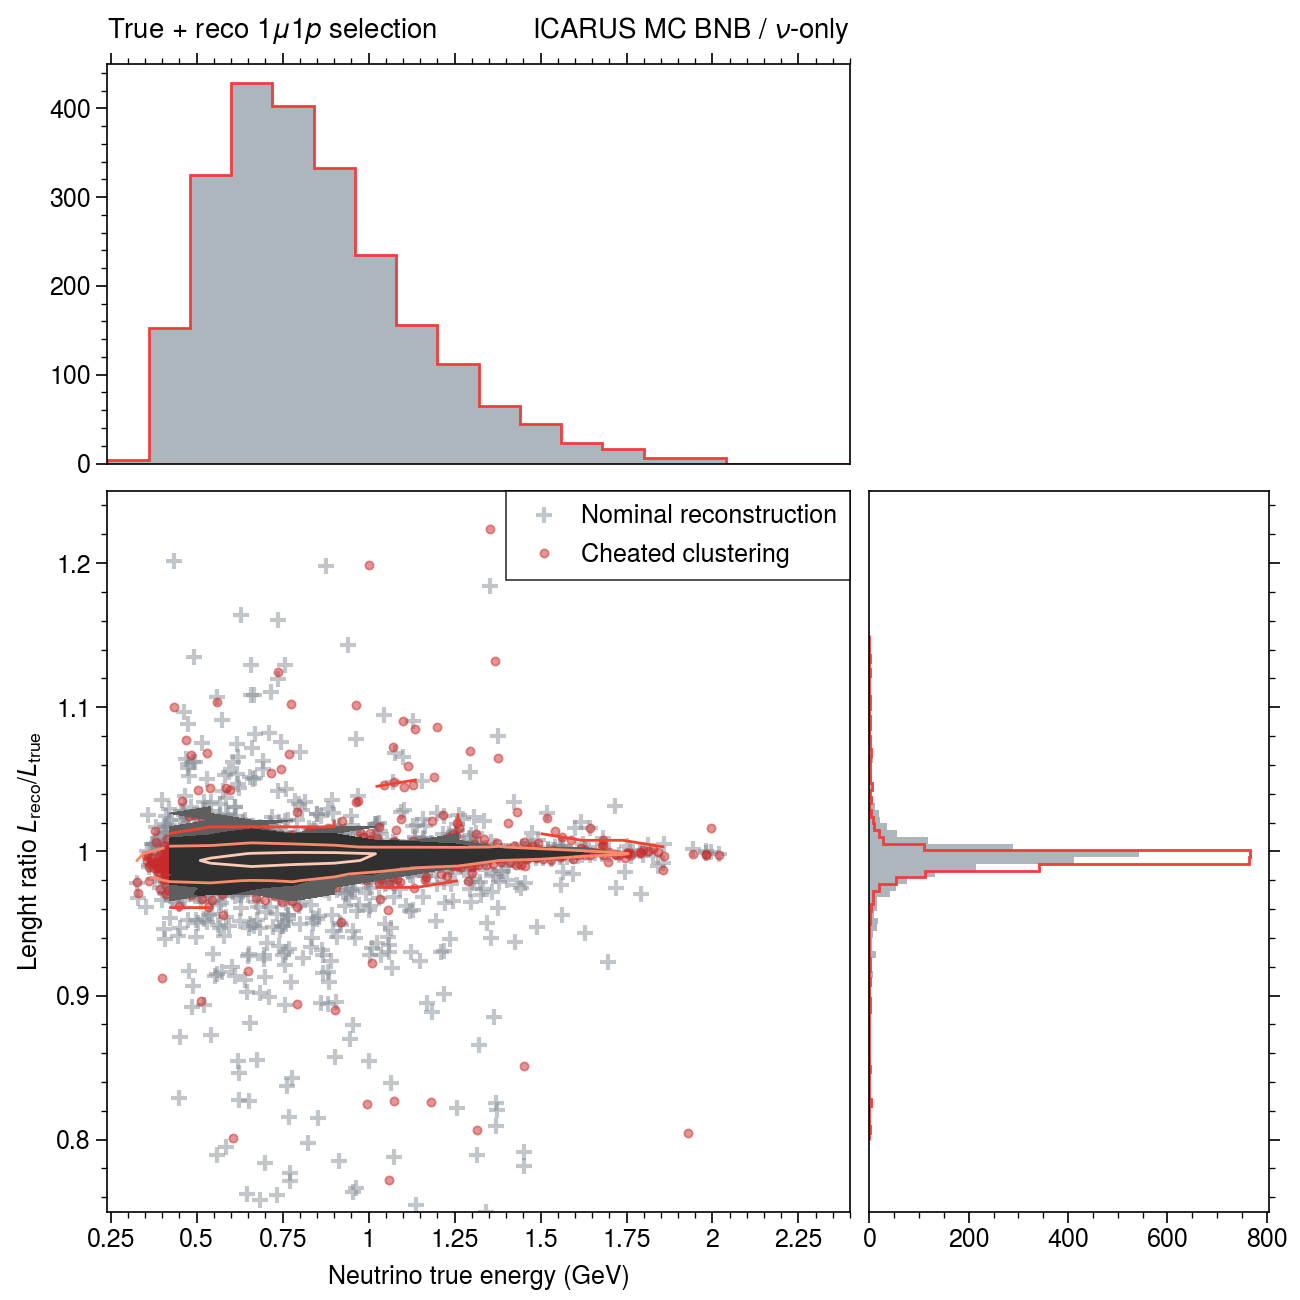

In [42]:
binning=[hist.axis.Regular(18, 0.24, 2.4), hist.axis.Regular(75, 0.8, 1.15)] # ratio, hit completeness
plot.rc['cmap.levels'] = 6

fig, axs = plot.subplots(
    width=6.5, height=6.5, ncols=1, nrows=1, 
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only',
    ltitle='True + reco $1\\mu1p$ selection',
    # yscale='log'
)

(a, b, c), (A, B, C) = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx'], ['true_E', 'pid_muon_L_reco_true_ratio'], binning=binning)

ax = axs[0]
A = A[(A.true_E>-100) & (A.pid_muon_L_reco_true_ratio>0)]
B = B[(B.true_E>-100) & (B.pid_muon_L_reco_true_ratio>0)]



ax.scatter(A.true_E, A.pid_muon_L_reco_true_ratio, color='gray6', alpha=0.5, marker='+', label='Nominal reconstruction')
ax.scatter(B.true_E, B.pid_muon_L_reco_true_ratio, color='red9', alpha=0.5, marker='.', label='Cheated clustering')


H, xe, ye = a.to_numpy()
H = np.ma.masked_where(H <= 3, H)
ax.contourf(xe, ye, H.T, norm=mpl.colors.LogNorm(), vmin=0.5, vmax=H.max(), cmap='Black', lw=0)
H, xe, ye = b.to_numpy()
H = np.ma.masked_where(H < 0.1, H)
ax.contour(xe, ye, H.T, cmap='Reds_r', norm=mpl.colors.LogNorm(), vmin=0.5, vmax=0.1*H.max(), alpha=1, lw=1, label='Cheated clustering')


top = ax.panel(side='t', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx', 'cheated_2d_vtx_3d_nu_mva'], 'true_E', binning=hist.axis.Regular(18, 0.24, 2.4, flow=False))
hep.histplot(A, ax=top, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5')
hep.histplot(B, ax=top, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1)

right = ax.panel(side='r', width=2)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx', 'cheated_2d_vtx_3d_nu_mva'], 'pid_muon_L_reco_true_ratio', binning=hist.axis.Regular(75, 0.8, 1.15))
hep.histplot(A.to_numpy(), ax=right, density=False, yerr=False, label=f'Nominal', histtype='fill', color='gray5', orientation='horizontal')
hep.histplot(B.to_numpy(), ax=right, density=False, yerr=False, label=f'Cheated clustering', color='red7', lw=1, orientation='horizontal')


right.format(
    xlabel=r'', ylabel='', ylim=(0.75, 1.25), grid=False
)
top.format(
    xlabel=r'', ylabel='', xlim=(0.24, 2.4), grid=False
)
ax.format(
    xlabel=r'Neutrino true energy (GeV)', ylabel=r'Lenght ratio $L_\text{reco}/L_\text{true}$',  
    xlim=(0.24, 2.4), ylim=(0.75, 1.25)
)
ax.legend(ncols=1, frameon=True)

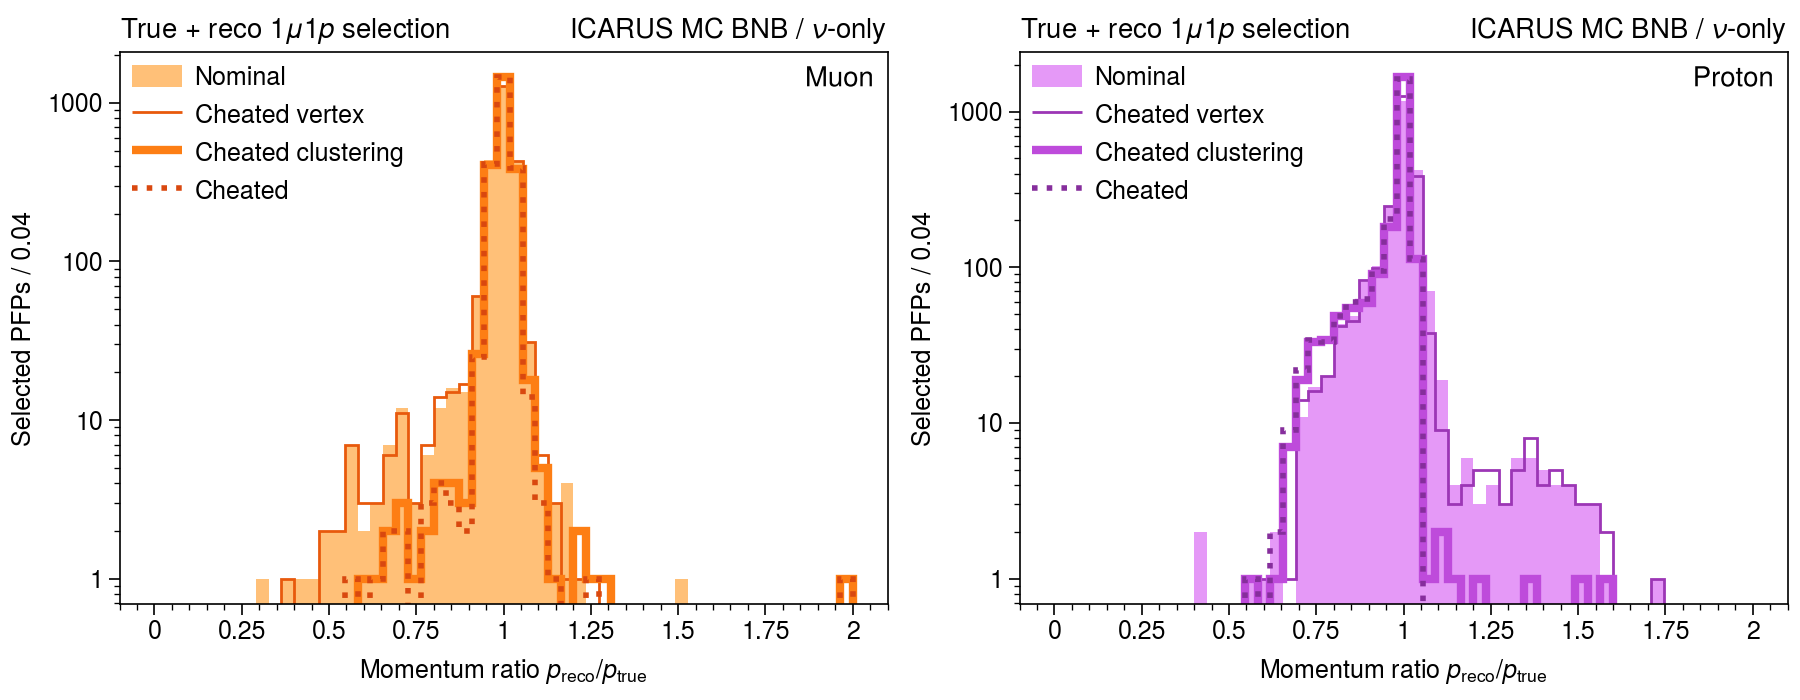

In [43]:
binning=hist.axis.Regular(55, 0, 2, flow=False)

fig, axs = plot.subplots(
    width=9, height=3.5, ncols=2, nrows=1, 
    xlabel=r'Momentum ratio $p_\text{reco}/p_\text{true}$', ylabel=f'Selected PFPs / {binning.widths[0]:.2f}',  
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only', 
    ltitle='True + reco $1\\mu1p$ selection',
    yscale='log'
)

label_dict = {
    'muon': 'Muon',
    'proton': 'Proton'
}

for ax, particle in zip(axs, ['muon', 'proton']):
    (A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx', 'cheated_2d_vtx_3d_nu_mva'], f'pid_{particle}_P_reco_true_ratio', binning=binning)
    hep.histplot(A, ax=ax, density=False, yerr=False, label=f'Nominal', histtype='fill', color=A_colors[particle])
    hep.histplot(C, ax=ax, density=False, yerr=False, label=f'Cheated vertex', color=C_colors[particle], lw=1)
    hep.histplot(B, ax=ax, density=False, yerr=False, label=f'Cheated clustering', color=B_colors[particle], lw=3)
    hep.histplot(D, ax=ax, density=False, yerr=False, label=f'Cheated', color=D_colors[particle], lw=2, ls=':')
    ax.format(urtitle=label_dict[particle])
    ax.legend(ncols=1, loc='ul')


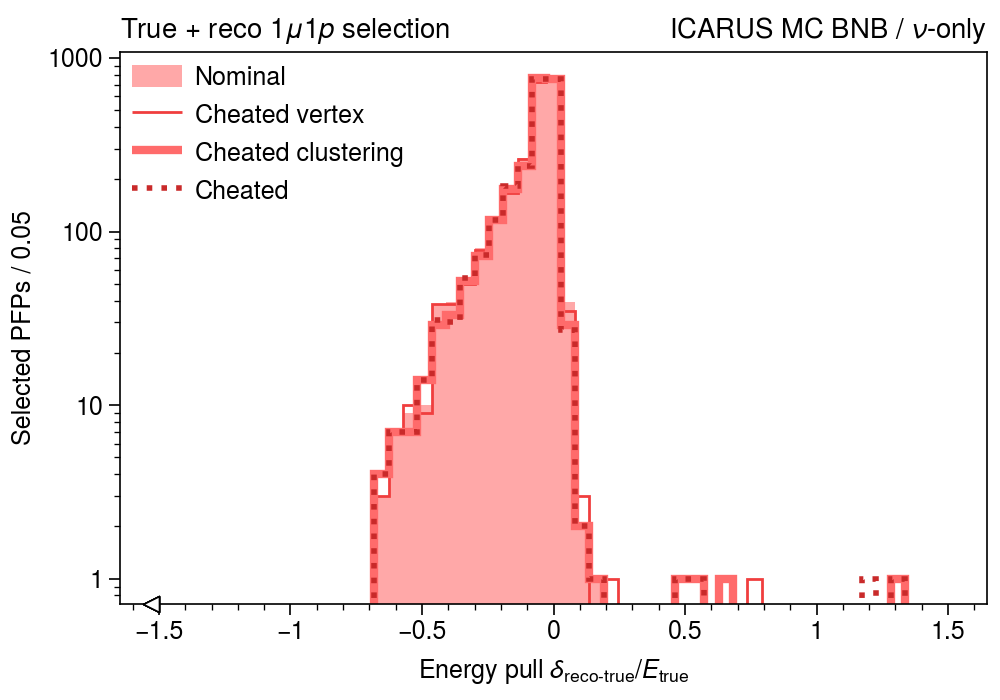

In [44]:
binning=hist.axis.Regular(55, -1.5, 1.5, overflow=False)

fig, ax = plot.subplots(
    width=5, height=3.5, ncols=1, nrows=1, 
    xlabel=r'Energy pull $\delta_\text{reco-true}/E_\text{true}$', ylabel=f'Selected PFPs / {binning.widths[0]:.2f}',  
    titlecolor='k', share=False, grid=False,
    rtitle='ICARUS MC BNB / $\\nu$-only', 
    ltitle='True + reco $1\\mu1p$ selection',
    yscale='log'
)

(A, B, C, D), _ = variables_1u1p.get(['nominal', 'cheated_2d', 'cheated_vtx', 'cheated_2d_vtx_3d_nu_mva'], 'dE', binning=binning)
hep.histplot(A, ax=ax[0], density=False, yerr=False, label=f'Nominal', histtype='fill', color='red3')
hep.histplot(C, ax=ax[0], density=False, yerr=False, label=f'Cheated vertex', color='red7', lw=1)
hep.histplot(B, ax=ax[0], density=False, yerr=False, label=f'Cheated clustering', color='red5', lw=3)
hep.histplot(D, ax=ax[0], density=False, yerr=False, label=f'Cheated', color='red9', lw=2, ls=':')
ax.legend(ncols=1, loc='ul')